<a href="https://colab.research.google.com/github/2303a52239/Explainable-AI-/blob/main/ExternalExam_2239.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **External Exam**

### **IMPORT LIBRARIES**

In [ ]:
!pip install catboost xgboost lightgbm imbalanced-learn shap lime tensorflow matplotlib seaborn scikit-learn pandas numpy --quiet



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, VotingClassifier
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Explainability
import shap
from lime.lime_tabular import LimeTabularExplainer

import warnings
warnings.filterwarnings('ignore')



### **LOAD DATASET**

In [ ]:
df = pd.read_csv("iti_student_dropout_dataset.csv")
print("✅ Dataset Loaded Successfully")
print("Shape:", df.shape)
print(df.head())

✅ Dataset Loaded Successfully
Shape: (7000, 23)
   gender location_type program_enrolled financial_aid_status part_time_work  \
0  Female         Urban              ECE              Partial            Yes   
1    Male         Rural       Electrical              Partial            Yes   
2    Male         Urban      Computer IT              Partial            Yes   
3    Male         Rural         Plumbing              Partial            Yes   
4  Female    Semi-urban              ECE              Partial            Yes   

  career_alignment family_support stress_levels internet_connectivity_issues  \
0              Low           High           Low                    No Issues   
1              Low         Medium        Medium            Occasional Issues   
2              Low            Low        Medium              Frequent Issues   
3           Medium            Low          High                    No Issues   
4              Low         Medium        Medium                    No I

### **DATA PREPROCESSING**

In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Encode categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Feature-Target Split
target_col = 'Dropout' if 'Dropout' in df.columns else df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance the dataset using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
print("\n✅ Data Preprocessing Complete")




✅ Data Preprocessing Complete


### **CORRELATION HEATMAP**

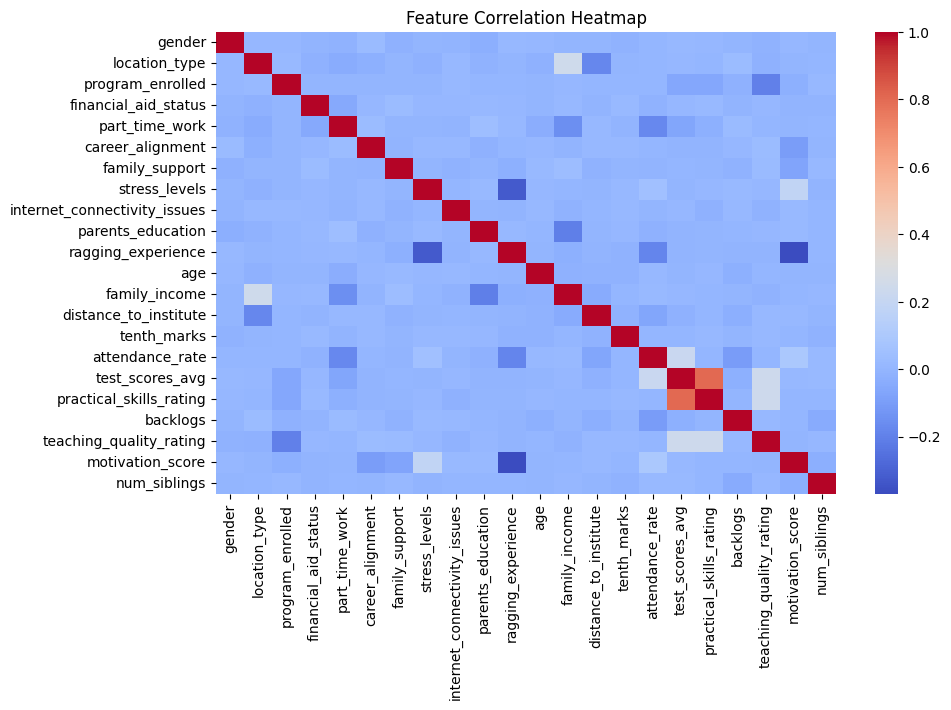

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.DataFrame(X_res, columns=X.columns).corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

### **BASIC VISUALIZATION**

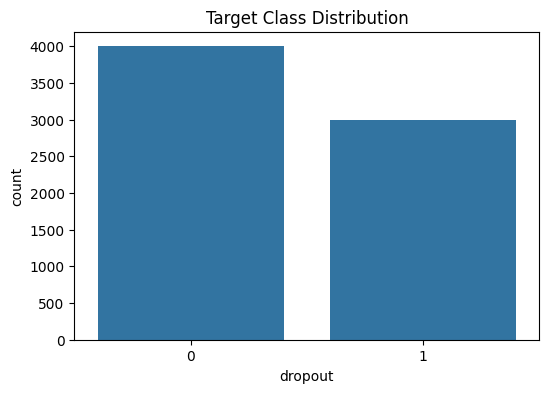

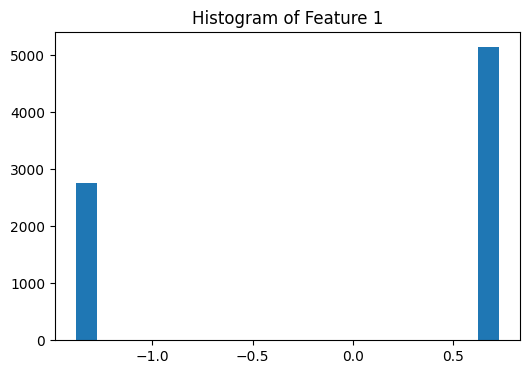

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Target Class Distribution")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(X_res[:,0], bins=20)
plt.title("Histogram of Feature 1")
plt.show()


### **MACHINE LEARNING MODELS**

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else [0]*len(y_pred)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_prob)
    results.append([name, acc, prec, rec, f1, auc_val])

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1-Score","AUC"])
print("\n📊 Machine Learning Results:\n")
print(results_df)


📊 Machine Learning Results:

                 Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Logistic Regression  0.900000   0.895334  0.902160  0.898734  0.967754
1        Decision Tree  0.843125   0.846253  0.832274  0.839206  0.842951
2                  KNN  0.852500   0.844806  0.857687  0.851198  0.927114
3          Naive Bayes  0.866250   0.901823  0.817027  0.857333  0.948416
4                  SVM  0.933750   0.925094  0.941550  0.933249  0.985345


### **ENSEMBLE MODELS**

In [ ]:
ensemble_models = {
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

for name, model in ensemble_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {acc:.3f}")

Random Forest: 0.917
Extra Trees: 0.922
AdaBoost: 0.921
Gradient Boosting: 0.932
XGBoost: 0.943
[LightGBM] [Info] Number of positive: 3213, number of negative: 3187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4552
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502031 -> initscore=0.008125
[LightGBM] [Info] Start training from score 0.008125
LightGBM: 0.943
CatBoost: 0.964


### **ROC CURVES FOR ALL MODELS**

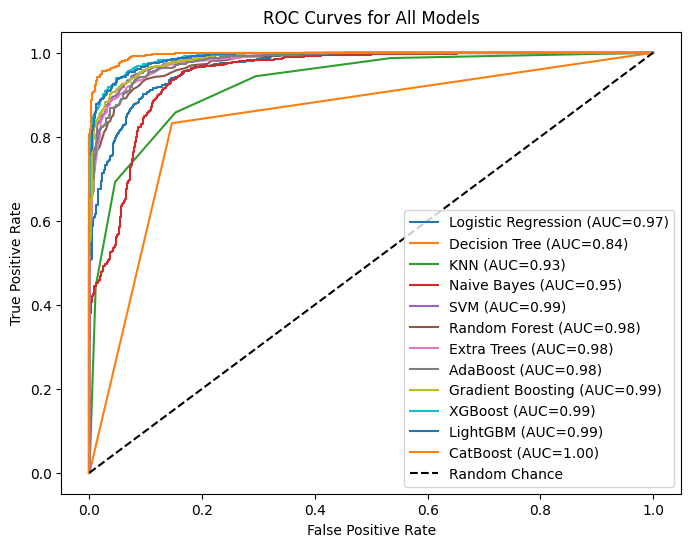

In [ ]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8,6))
for name, model in {**models, **ensemble_models}.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.2f})")

plt.plot([0,1],[0,1],'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.show()

### **CONFUSION MATRIX (Random Forest Example)**

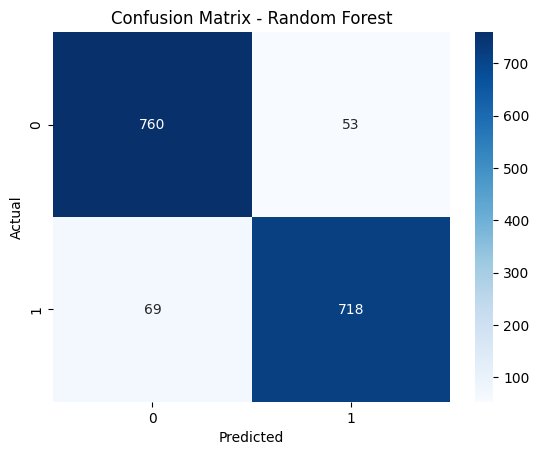

In [ ]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### **DEEP LEARNING MODEL (MLP)**

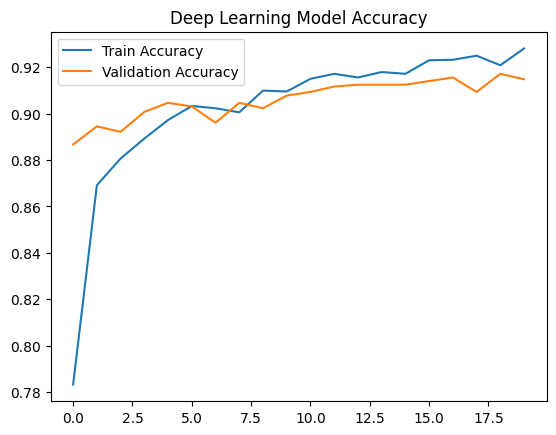

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


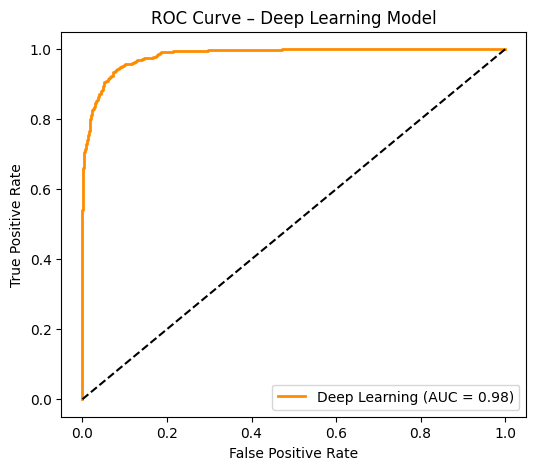

In [ ]:
model_dl = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_dl.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Deep Learning Model Accuracy")
plt.show()

# ROC for Deep Learning Model
y_prob_dl = model_dl.predict(X_test).ravel()
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_prob_dl)
roc_auc_dl = auc(fpr_dl, tpr_dl)

plt.figure(figsize=(6,5))
plt.plot(fpr_dl, tpr_dl, color='darkorange', lw=2, label=f'Deep Learning (AUC = {roc_auc_dl:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Deep Learning Model")
plt.legend()
plt.show()

### **XAI TECHNIQUES – SHAP + LIME**


🔹 Generating Explainable AI (XAI) visualizations...
Generating SHAP values...
✅ SHAP values computed successfully!


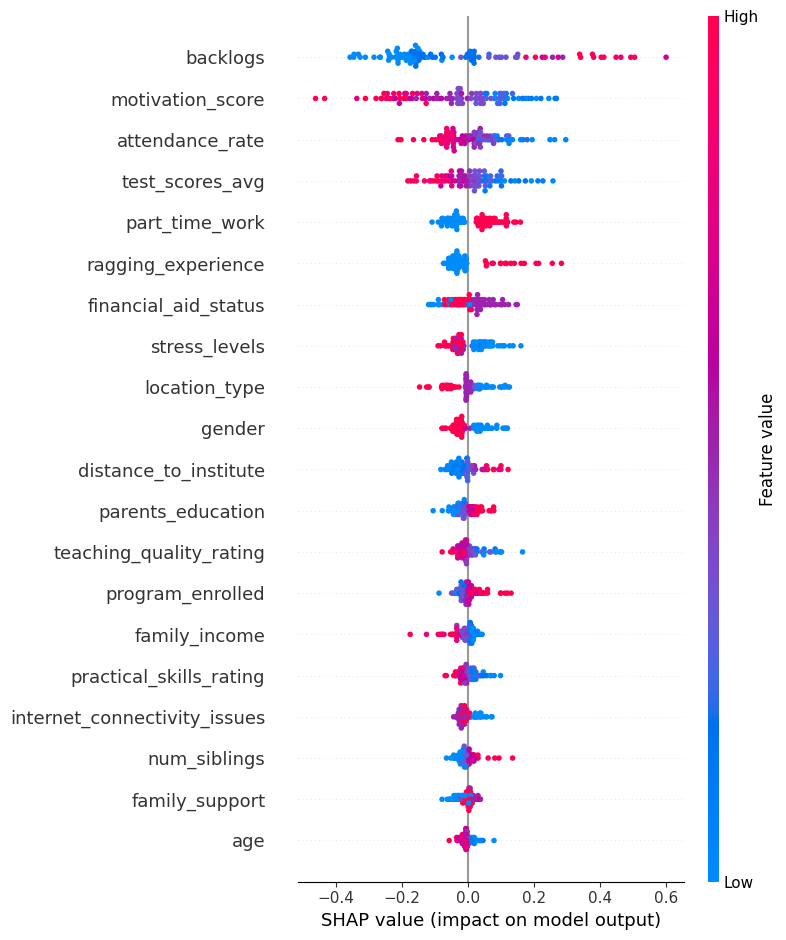


Generating LIME explanation for one sample...
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
print("\n🔹 Generating Explainable AI (XAI) visualizations...")

# ---------- SHAP ----------
X_sample = X_test[:100]
print("Generating SHAP values...")

explainer = shap.DeepExplainer(model_dl, X_train[:100])
shap_values = explainer.shap_values(X_sample)

if isinstance(shap_values, list):
    shap_values = shap_values[0]
if len(shap_values.shape) > 2:
    shap_values = shap_values.squeeze()

print("✅ SHAP values computed successfully!")
shap.summary_plot(shap_values, X_sample, feature_names=X.columns)

# ---------- LIME ----------
print("\nGenerating LIME explanation for one sample...")

def predict_fn(x):
    probs = model_dl.predict(x)
    return np.hstack((1 - probs, probs))

lime_explainer = LimeTabularExplainer(
    X_train,
    feature_names=X.columns,
    class_names=['No', 'Yes'],
    mode='classification'
)

exp = lime_explainer.explain_instance(X_test[0], predict_fn, num_features=10)
exp.show_in_notebook()



### **ICE & PDP (Partial Dependence Analysis)**


🔹 Generating ICE and PDP visualizations...
⚠️ Skipping feature 'gender' due to error: cannot reshape array of size 1 into shape (2)


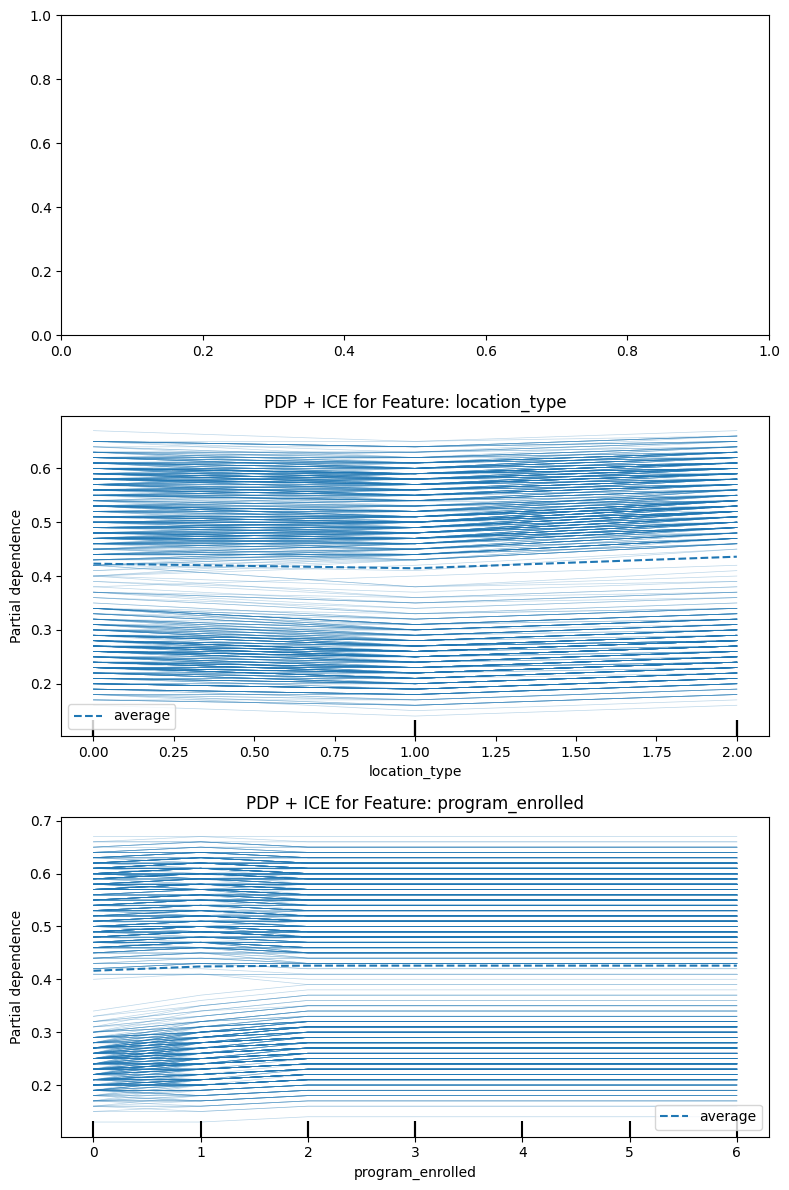

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

print("\n🔹 Generating ICE and PDP visualizations...")

ml_model = rf_model  # use best performing ML model
important_features = X.columns[:3]

response_method = "predict_proba" if hasattr(ml_model, "predict_proba") else "auto"

fig, ax = plt.subplots(len(important_features), 1, figsize=(8, 12))

for i, feature in enumerate(important_features):
    try:
        PartialDependenceDisplay.from_estimator(
            ml_model,
            X,
            [feature],
            kind="both",  # PDP + ICE
            ax=ax[i],
            grid_resolution=30,
            response_method=response_method
        )
        ax[i].set_title(f'PDP + ICE for Feature: {feature}', fontsize=12)
        ax[i].grid(True)
    except Exception as e:
        print(f"⚠️ Skipping feature '{feature}' due to error: {e}")

plt.tight_layout()
plt.show()